# Integrate CustomGPR class and save models

## Train models

In [1]:
import sys
sys.path.append('..')
import postmerger as pm
import numpy as np
import os
repo = os.environ["RINGREPO"]  # set to use on different machines
# sys.path.append(repo + "/code")
sys.path.append(repo)
import load_data_v2 as ld
import GPR_regressor_class as gprcl
import time
import joblib

Load data

In [2]:
subsample = 0
mode = (2,2)
features = 'X_6d_theta'
y_fit = "abs_err" # amp, t_emop, abs_err
notes = "LogWeights"

if True:

    sub = ld.SourcesSubset(
        cut_condition="bad_fit",
        # cut_condition="transitional_bad_names",
        print_info=True,
        data_for_goodness_of_fit=[20, "EMOP", "out_ROT2"],
        modes_for_goodness_of_fit=[mode],
        status_subsample=subsample,
    )

    names_array = sub.names_array


    [
        mode_list,
        new_mode_list,
        status_array,
        angle_array,  # between initial L (computed as J - S1 - S2) and rem spin vec
        omega_angle_array,  # between initial L (computed) and J (initial_ADM_angular_momentum)
        j_rem_angle,  # between J (initial_ADM_angular_momentum) and rem spin vec
        beta_angle,  # between rem_spin_vector and z-component of rem_spin
        theta2_isco_pro,  # between L (computed as J - S1 - S2) at isco_prograde and rem spin vec
        theta2_peak22,  # between L (computed as J - S1 - S2) at peak22 and rem spin vec
        remnant_spin_x,
        remnant_spin_y,
        remnant_spin_z,
        remnant_spin_vector,
        remnant_spin_array,  # Norm of the vector
        remnant_mass_array,
        chip_ISCO_array,
        chip_array,
        q_array,
        eta_array,
        delta_array,
        mass1_array,
        mass2_array,
        Lx_array,
        Ly_array,
        Lz_array,
        L_ISCO_vector,
        J_adm_ini,
        J_hor_ini,
        J_ISCO_vector,
        ecc_array,
        separation_array,
        chi1x_ISCO,
        chi1y_ISCO,
        chi1z_ISCO,
        chi1_ISCO_mag,
        chi2x_ISCO,
        chi2y_ISCO,
        chi2z_ISCO,
        chi2_ISCO_mag,
        chi_plus_ISCO,
        chi_odd_ISCO,
        chi1x_array,
        chi1y_array,
        chi1_array,  # z_comp
        chi2x_array,
        chi2y_array,
        chi2_array,  # z_comp
        chi_plus_array,
        chi_odd_array,
        chi1x_rot,
        chi1y_rot,
        chi1z_rot,
        chi2x_rot,
        chi2y_rot,
        chi2z_rot,
        chi_plus_rot,
        chi_minus_rot,
        chi_odd_rot,
        chi1x_rot_ISCO,
        chi1y_rot_ISCO,
        chi1z_rot_ISCO,
        chi2x_rot_ISCO,
        chi2y_rot_ISCO,
        chi2z_rot_ISCO,
        chi_plus_rot_ISCO,
        chi_minus_rot_ISCO,
        chi_odd_rot_ISCO,
        fixed_freq_array,
        fixed_tau_array,
        fixed_omegaRE_array,
        fixed_omegaIM_array,
        kick_vel_vector,
        kick_angle,
        chi1_r_rot_ISCO,
        chi1_lat_rot_ISCO,
        chi1_lon_rot_ISCO,
        chi2_r_rot_ISCO,
        chi2_lat_rot_ISCO,
        chi2_lon_rot_ISCO,
        chi1x_rot_L,
        chi1y_rot_L,
        chi1z_rot_L,
        chi2x_rot_L,
        chi2y_rot_L,
        chi2z_rot_L,
        chi_plus_rot_L,
        chi_minus_rot_L,
        chi_odd_rot_L,
        chi1x_rot_ISCO_L,
        chi1y_rot_ISCO_L,
        chi1z_rot_ISCO_L,
        chi2x_rot_ISCO_L,
        chi2y_rot_ISCO_L,
        chi2z_rot_ISCO_L,
        chi_plus_rot_ISCO_L,
        chi_minus_rot_ISCO_L,
        chi_odd_rot_ISCO_L,
        kick_vel,
        fixed_freq_array_ret,
        fixed_tau_array_ret,
        fixed_omegaRE_array_ret,
        fixed_omegaIM_array_ret,
    ] = ld.load_binary_params(names_array)


    X_7d_ISCO = np.vstack(
        (
            delta_array,
            chi1x_rot_ISCO,
            chi1y_rot_ISCO,
            chi1z_rot_ISCO,
            chi2x_rot_ISCO,
            chi2y_rot_ISCO,
            chi2z_rot_ISCO,
        )
    ).T

    X_6d_theta = np.vstack(
        (
            delta_array,
            chi_plus_rot_ISCO,
            chi_minus_rot_ISCO,
            theta2_isco_pro,
            kick_angle,
            kick_vel,
        )
    ).T

    if features == "X_7d_ISCO":
        X = X_7d_ISCO
    elif features == "X_6d_theta":
        X = X_6d_theta
    else:
        raise ValueError("Invalid 'features' argument. Choose one of the available")

    mode_list = sub.new_mode_list
    mode_n = mode_list.index(mode)

    fit_data_d = ld.load_fit_data(names_array, 20, "EMOP", "out_ROT2")
    new_amp_array = fit_data_d["new_amp_array"]
    new_error_zhu = fit_data_d["new_error_zhu"]

    emop_d = ld.load_emop_data(names_array, "out_ROT2")
    emop_abs_t_array = emop_d["emop_abs_t_array"]
    emop_array = emop_d["emop_array"]
    peak_d = ld.load_peak_data(names_array, "out_ROT2")
    peak_tot_array = peak_d["peak_tot_array"]
    delta_emop_t = emop_abs_t_array - peak_tot_array

    if y_fit == "amp":
        y = new_amp_array[:, mode_n]
    elif y_fit == "t_emop":
        y = delta_emop_t
    elif y_fit == "abs_err":
        cvmod = gprcl.CrossValModel(
            n_to_leave_out=1,
            mode=mode,
            features=features,
            linear_fit=False,
            subsample=0,
            use_scaler=True,
            y_fit="amp",
            notes="LogWeights",
        )
        cvmod.load_cv_data()
        err_subsample_list = [
            "all",
            "non_spinning",
            "spinning_aligned",
            "aligned",
            "precessing",
            "original",
        ]
        err_subsample = err_subsample_list[subsample]
        cvmod.compute_cv_stats(err_subsample=err_subsample, rel_err_rebinning=False)
        abs_err = np.abs(cvmod.abs_err)
        y = abs_err

    err = new_error_zhu[:, mode_n]
    usable_err_max = np.max(err[err < 1.0])
    clipped_err = np.clip(
        err, a_min=None, a_max=usable_err_max
    )  # Clip because sometimes error > 1 when offset is present in waveform.
    dy = -1 / np.log10(clipped_err) + 1e-10  # const is default sklearn value
    
    if y_fit == "t_emop":
        dy = np.full_like(y, 1e-5)
    
    nparams = X.shape[1]
    npoints = X.shape[0]

    model_name = gprcl.model_name_fun(
        mode=mode,
        y_fit=y_fit,
        features=features,
        linear_fit=False,
        subsample=subsample,
        use_scaler=True,
        notes=notes,
    )
    

Excluded simulations = 151
Loaded simulations = 1866


Fit model

In [3]:
print(f"Fitting model: {model_name}")

gpr_pipe = pm.CustomGPR()

gpr_pipe.fit(X = X, y=y, 
             sample_weight = 1/dy,
             linear_fit = False,
             precessing = True)
  

Fitting model: gpr_pipe_abs_err_22_X_6d_theta_linFalse_scalTrue_sample0_LogWeights


KeyboardInterrupt: 

Save model

In [9]:
amp_models_dict = {
    mode: gpr_pipe
}

AmplitudeFit6dq10Prec_dict = {
    'time_from_temop': 20,
    'amps': amp_models_dict}


savefile = "AmplitudeFit6dq10Prec_dict.pkl"
with open(savefile, "wb") as f:
    joblib.dump(AmplitudeFit6dq10Prec_dict, f)

## Modify dicts if needed

In [18]:
import sys
sys.path.append('..')
import postmerger as pm
import numpy as np
import os
repo = os.environ["RINGREPO"]  # set to use on different machines
# sys.path.append(repo + "/code")
sys.path.append(repo)
import load_data_v2 as ld
import GPR_regressor_class as gprcl
import time
import joblib


In [19]:
save_filepath = "/home/fra/ringdown/postmerger/postmerger/data/trained_models/"

save_file = save_filepath + "Prec7dq10.pkl"
feature_set = '7d'

# save_file = save_filepath + "Prec6dq10.pkl"
# feature_set = '6d'

with open(save_file, "rb") as f:
    loaded_model_dict = joblib.load(f)
    
loaded_model_dict.keys()

dict_keys(['time_from_temop', 'amps', 'abs_err', 't_emop', 'feature_set'])

In [20]:
loaded_model_dict2 = loaded_model_dict.copy()

In [3]:
loaded_model_dict['feature_set'] = feature_set

updated_model_dict = loaded_model_dict

for key, obj in loaded_model_dict['amps'].items():
    updated_model_dict['amps'][key] = {(key[0], key[1], 0): obj}

for key, obj in loaded_model_dict['abs_err'].items():
    updated_model_dict['abs_err'][key] = {(key[0], key[1], 0): obj}



In [4]:
# with open(save_file, "wb") as f:
#     joblib.dump(updated_model_dict, f)

## Scatterplots from saved models

We can check by eye if all models are predicting sensible values

In [1]:
import sys
sys.path.append('..')
import postmerger as pm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
repo = os.environ["RINGREPO"]  # set to use on different machines
# sys.path.append(repo + "/code")
sys.path.append(repo)
import load_data_v2 as ld
import joblib
import pandas as pd
import GPR_regressor_class as gprcl


def plot_single_pair(
    ax,
    feature_ind1,
    feature_ind2,
    _X,
    _y,
    _dy,
    _dy_scale,
    _features,
    _max,
    _min,
    log_color=False,
    cmap="magma",
    cbar_between_percentiles=False,
    plot_histograms_diagonal=True,
    **kwargs,
):
    """Plots single pair of features.

    Parameters
    ----------
    ax : Axes
        matplotlib axis to be plotted
    feature_ind1 : int
        index of first feature to be plotted
    feature_ind2 : int
        index of second feature to be plotted
    _X : numpy.ndarray
        Feature dataset of of shape m x n
    _y : numpy.ndarray
        Target list of shape 1 x n
    _features : list of str
        List of n feature titles
    colormap : dict
        Color map of classes existing in target

    Returns
    -------
    None
    """

    # Plot distribution histogram if the features are the same (diagonal of the pair-plot).
    if plot_histograms_diagonal == True:
        if feature_ind1 == feature_ind2:
            tdf = pd.DataFrame(_X[:, [feature_ind1]], columns=[_features[feature_ind1]])
            tdf["target"] = _y
            # ax[feature_ind1, feature_ind2].hist(tdf[_features[feature_ind1]], color = 'grey', bins = 30)
            im = ax.hist(tdf[_features[feature_ind1]], color="grey", bins=30)

        else:
            # other wise plot the pair-wise scatter plot
            tdf = pd.DataFrame(
                _X[:, [feature_ind1, feature_ind2]],
                columns=[_features[feature_ind1], _features[feature_ind2]],
            )
            tdf["target"] = _y
            # ax[feature_ind1, feature_ind2].scatter(x = tdf[_features[feature_ind2]], y = tdf[_features[feature_ind1]], c=y, cmap='magma',s=dy*15, alpha=0.7, linewidth=0)
            if log_color == True:
                if cbar_between_percentiles == True:
                    im = ax.scatter(
                        x=tdf[_features[feature_ind2]],
                        y=tdf[_features[feature_ind1]],
                        c=_y,
                        cmap=cmap,
                        s=_dy * _dy_scale,
                        alpha=0.6,
                        linewidth=0,
                        norm=mpl.colors.SymLogNorm(
                            linthresh=_min * 0.99,
                            linscale=1,
                            vmin=np.percentile(_y, 5),
                            vmax=np.percentile(_y, 95),
                            base=10,
                        ),
                        **kwargs,
                    )
                else:
                    im = ax.scatter(
                        x=tdf[_features[feature_ind2]],
                        y=tdf[_features[feature_ind1]],
                        c=_y,
                        cmap=cmap,
                        s=_dy * _dy_scale,
                        alpha=0.6,
                        linewidth=0,
                        norm=mpl.colors.SymLogNorm(
                            linthresh=_min * 0.99,
                            linscale=1,
                            vmin=_min,
                            vmax=_max,
                            base=10,
                        ),
                        **kwargs,
                    )
            else:
                if cbar_between_percentiles == True:
                    im = ax.scatter(
                        x=tdf[_features[feature_ind2]],
                        y=tdf[_features[feature_ind1]],
                        c=_y,
                        cmap=cmap,
                        s=_dy * _dy_scale,
                        alpha=0.6,
                        linewidth=0,
                        norm=mpl.colors.Normalize(
                            vmin=np.percentile(_y, 5),
                            vmax=np.percentile(_y, 95),
                        ),
                        **kwargs,
                    )
                else:
                    im = ax.scatter(
                        x=tdf[_features[feature_ind2]],
                        y=tdf[_features[feature_ind1]],
                        c=_y,
                        cmap=cmap,
                        s=_dy * _dy_scale,
                        alpha=0.6,
                        linewidth=0,
                        vmin=_min,
                        vmax=_max,
                        **kwargs,
                    )

        # Print the feature labels only on the left side of the pair-plot figure
        # and bottom side of the pair-plot figure.
        # Here avoiding printing the labels for inner axis plots.
        if feature_ind1 == len(_features) - 1:
            ax.set(xlabel=_features[feature_ind2], ylabel="")
            # ax[feature_ind1, feature_ind2].set(xlabel=_features[feature_ind2], ylabel='')
        if feature_ind2 == 0:
            if feature_ind1 == len(_features) - 1:
                ax.set(xlabel=_features[feature_ind2], ylabel=_features[feature_ind1])
                # ax[feature_ind1, feature_ind2].set(xlabel=_features[feature_ind2], ylabel=_features[feature_ind1])
            else:
                # ax[feature_ind1, feature_ind2].set(xlabel='', ylabel=_features[feature_ind1])
                ax.set(xlabel="", ylabel=_features[feature_ind1])

    return im


def myplotGrid(
    X,
    y,
    dy,
    dy_scale,
    features,
    max,
    min,
    target_hist=True,
    target_hist_log=False,
    cbar_label="Target feature",
    figsize=None,
    log_color=False,
    cmap="magma",
    cbar_between_percentiles=False,
    **kwargs,
):
    """Plots a pair grid of the given features.

    Parameters
    ----------
    X : numpy.ndarray
        Dataset of shape m x n
    y : numpy.ndarray
        Target list of shape 1 x n
    features : list of str
        List of n feature titles

    Returns
    -------
    figure
    """

    feature_count = len(features)

    fig = plt.figure()

    if figsize is None:
        fig.set_size_inches(feature_count * 4, feature_count * 4)
    else:
        fig.set_size_inches(figsize)

    width_ratios = [1] * feature_count
    width_ratios.append(0.1)
    gs = mpl.gridspec.GridSpec(
        feature_count,
        feature_count + 1,
        figure=fig,
        width_ratios=width_ratios,
        wspace=0.08,
        hspace=0.08,
    )

    # Iterate through features to plot pairwise.
    for i in range(0, feature_count):
        for j in range(0, feature_count):
            if i >= j:
                axis = fig.add_subplot(gs[i, j])
                axis.xaxis.set_major_locator(plt.MaxNLocator(5))
                axis.yaxis.set_major_locator(plt.MaxNLocator(5))
                axis.grid(ls="--", alpha=0.3)
                if i != feature_count - 1:
                    plt.setp(axis.get_xticklabels(), visible=False)
                if j != 0:
                    plt.setp(axis.get_yticklabels(), visible=False)
                if i == feature_count - 1:
                    plt.setp(
                        axis.get_xticklabels(), rotation=30, horizontalalignment="right"
                    )
                im = plot_single_pair(
                    axis,
                    i,
                    j,
                    X,
                    y,
                    dy,
                    dy_scale,
                    features,
                    max,
                    min,
                    log_color=log_color,
                    cmap=cmap,
                    cbar_between_percentiles=cbar_between_percentiles,
                )

    ###### Add color bar to the right side of the pair-plot figure.

    if log_color == True:

        if cbar_between_percentiles == True:
            norm = mpl.colors.SymLogNorm(
                linthresh=min * 0.99,
                linscale=1,
                vmin=np.percentile(y, 5),
                vmax=np.percentile(y, 95),
                base=10,
            )
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            cb = fig.colorbar(
                sm,
                cax=plt.subplot(gs[:, -1]),
                label=cbar_label,
                ticks=np.logspace(
                    np.log10(np.percentile(y, 5)), np.log10(np.percentile(y, 95)), 10
                ),
                format=mpl.ticker.FuncFormatter(lambda x, _: "{:.1e}".format(x)),
                extend="both",
            )
        else:
            norm = mpl.colors.SymLogNorm(
                linthresh=min * 0.99,
                linscale=1,
                vmin=min,
                vmax=max,
                base=10,
            )
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            cb = fig.colorbar(
                sm,
                cax=plt.subplot(gs[:, -1]),
                label=cbar_label,
                ticks=[0.0] + np.logspace(np.log10(min), np.log10(max), 10).tolist(),
                format=mpl.ticker.FuncFormatter(lambda x, _: "{:.1e}".format(x)),
            )

    else:
        if cbar_between_percentiles == True:
            norm = mpl.colors.Normalize(
                vmin=np.percentile(y, 5),
                vmax=np.percentile(y, 95),
            )
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            cb = fig.colorbar(
                sm,
                cax=plt.subplot(gs[:, -1]),
                label=cbar_label,
                extend="both",
            )
        else:
            norm = mpl.colors.Normalize(vmin=min, vmax=max)
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            cb = fig.colorbar(
                sm,
                cax=plt.subplot(gs[:, -1]),
                label=cbar_label,
            )

    if target_hist == True:
        ax = fig.add_subplot(gs[0:1, -3:-1])

        if (target_hist_log == True) & (np.any(y > 0.0)):
            bins = np.logspace(
                np.min(np.log10(y[y > 0.0])), (np.max(np.log10(y[y > 0.0]))), 30
            )
            ax.set_xscale("log")
            ax.axvline(x=np.percentile(y[y > 0.0], 95), color="r", ls="--")
            ax.axvline(x=np.percentile(y[y > 0.0], 5), color="r", ls="--")
            ax.axvline(x=np.percentile(y[y > 0.0], 50), color="k", ls="--")
        else:
            bins = 30
            ax.axvline(x=np.percentile(y, 95), color="r", ls="--")
            ax.axvline(x=np.percentile(y, 5), color="r", ls="--")
            ax.axvline(x=np.percentile(y, 50), color="k", ls="--")

        ax.hist(y, color="lightblue", bins=bins)
        plt.setp(
            ax.xaxis.get_majorticklabels(), rotation=30, horizontalalignment="right"
        )
        plt.setp(
            ax.xaxis.get_minorticklabels(), rotation=30, horizontalalignment="right"
        )
        ax.grid(ls="--", alpha=0.3)
        ax.set_xlabel("Target feature")

    return fig


def plot_corner(
    quantity,
    plot_subsample,
    target_hist_log,
    feature_set: str,
    savefig=False,
    chosen_modes=None,
    log_color=False,
    cmap="magma",
    cbar_between_percentiles=False,
    custom_data=None,
    custom_data_names=None,
    plot_t_emop_GPR=False,
    gpr_models_dict=None,
):
    """
    Plot a corner plot for a given quantity and plot subsample.

    Parameters:
    - quantity (str): The quantity to plot.
    - plot_subsample (str): The plot subsample to use. Can be one of "all", "small_theta", "big_theta", "aligned".
    - target_hist_log (bool): Whether to use logarithmic scale for the target histogram.
    - feature_set (str): The feature set to use. Can be one of "5d", "7d".
    - savefig (bool, optional): Whether to save the figure. Defaults to False.
    - chosen_modes (list, optional): List of modes to plot. Defaults to None.
    - log_color (bool, optional): Whether to use logarithmic color scale. Defaults to False.
    """

    sub = ld.SourcesSubset(
        cut_condition="transitional_bad_names",
        print_info=False,
        status_subsample=0,
    )

    master_mode_list = sub.new_mode_list

    ##---------------------------------------------------------------------------------------
    if plot_subsample == "all":
        title1 = r"All $\theta_{\rm f}$"
        cv_err_subsample = "all"
    elif plot_subsample == "small_theta":
        title1 = r"Precessing sources $\theta_{\rm f} < 0.25 \sim 14^{\circ}$"
        cv_err_subsample = "all"
    elif plot_subsample == "big_theta":
        title1 = r"$\theta_{\rm f} > 0.5 \sim 28^{\circ}$"
        cv_err_subsample = "all"
    elif plot_subsample == "aligned":
        title1 = r"Aligned"
        cv_err_subsample = "aligned"
    else:
        raise ValueError("plot_subsample not recognized")

    ##-------------------------

    if quantity in ["amplitudes", "retrograde_amp", "GPR_pred", "GPR_sigma"]:
        cut_condition = "transitional_bad_names"
    else:
        cut_condition = "bad_fit"

    ##-------------------------

    modes = master_mode_list
    if chosen_modes is not None:
        modes = chosen_modes

    for mode in modes:

        status_subsample = 0

        sub = ld.SourcesSubset(
            cut_condition=cut_condition,
            print_info=False,
            # data_for_goodness_of_fit=[20, "EMOP", "out_ROT2"],
            modes_for_goodness_of_fit=[mode],
            status_subsample=0,
            # real_20=True,
        )

        names_func = sub.names_array

        if plot_subsample == "all":
            names_array = sub.names_array
            # rule = sub.theta2_isco_pro < 1000
            chosen_subsample_names = sub.names_array

        elif plot_subsample == "small_theta":
            names_array = sub.names_array[
                (sub.theta2_isco_pro < 0.25) & (sub.status_array == "precessing")
            ]
            rule = (sub.theta2_isco_pro < 0.25) & (sub.status_array == "precessing")
            chosen_subsample_names = sub.names_array[rule]

        elif plot_subsample == "big_theta":
            names_array = sub.names_array[(sub.theta2_isco_pro > 0.5)]
            rule = sub.theta2_isco_pro > 0.5
            chosen_subsample_names = sub.names_array[rule]

        elif plot_subsample == "aligned":

            rule = (sub.status_array == "non_spinning") | (
                sub.status_array == "spinning_aligned"
            )
            names_array = sub.names_array[rule]
            chosen_subsample_names = sub.names_array[rule]

        else:
            raise ValueError("plot_subsample not recognized")

        [
            mode_list,
            new_mode_list,
            status_array,
            angle_array,  # between initial L (computed as J - S1 - S2) and rem spin vec
            omega_angle_array,  # between initial L (computed) and J (initial_ADM_angular_momentum)
            j_rem_angle,  # between J (initial_ADM_angular_momentum) and rem spin vec
            beta_angle,  # between rem_spin_vector and z-component of rem_spin
            theta2_isco_pro,  # between L (computed as J - S1 - S2) at isco_prograde and rem spin vec
            theta2_peak22,  # between L (computed as J - S1 - S2) at peak22 and rem spin vec
            remnant_spin_x,
            remnant_spin_y,
            remnant_spin_z,
            remnant_spin_vector,
            remnant_spin_array,  # Norm of the vector
            remnant_mass_array,
            chip_ISCO_array,
            chip_array,
            q_array,
            eta_array,
            delta_array,
            mass1_array,
            mass2_array,
            Lx_array,
            Ly_array,
            Lz_array,
            L_ISCO_vector,
            J_adm_ini,
            J_hor_ini,
            J_ISCO_vector,
            ecc_array,
            separation_array,
            chi1x_ISCO,
            chi1y_ISCO,
            chi1z_ISCO,
            chi1_ISCO_mag,
            chi2x_ISCO,
            chi2y_ISCO,
            chi2z_ISCO,
            chi2_ISCO_mag,
            chi_plus_ISCO,
            chi_odd_ISCO,
            chi1x_array,
            chi1y_array,
            chi1_array,  # z_comp
            chi2x_array,
            chi2y_array,
            chi2_array,  # z_comp
            chi_plus_array,
            chi_odd_array,
            chi1x_rot,
            chi1y_rot,
            chi1z_rot,
            chi2x_rot,
            chi2y_rot,
            chi2z_rot,
            chi_plus_rot,
            chi_minus_rot,
            chi_odd_rot,
            chi1x_rot_ISCO,
            chi1y_rot_ISCO,
            chi1z_rot_ISCO,
            chi2x_rot_ISCO,
            chi2y_rot_ISCO,
            chi2z_rot_ISCO,
            chi_plus_rot_ISCO,
            chi_minus_rot_ISCO,
            chi_odd_rot_ISCO,
            fixed_freq_array,
            fixed_tau_array,
            fixed_omegaRE_array,
            fixed_omegaIM_array,
            kick_vel_vector,
            kick_angle,
            chi1_r_rot_ISCO,
            chi1_lat_rot_ISCO,
            chi1_lon_rot_ISCO,
            chi2_r_rot_ISCO,
            chi2_lat_rot_ISCO,
            chi2_lon_rot_ISCO,
            chi1x_rot_L,
            chi1y_rot_L,
            chi1z_rot_L,
            chi2x_rot_L,
            chi2y_rot_L,
            chi2z_rot_L,
            chi_plus_rot_L,
            chi_minus_rot_L,
            chi_odd_rot_L,
            chi1x_rot_ISCO_L,
            chi1y_rot_ISCO_L,
            chi1z_rot_ISCO_L,
            chi2x_rot_ISCO_L,
            chi2y_rot_ISCO_L,
            chi2z_rot_ISCO_L,
            chi_plus_rot_ISCO_L,
            chi_minus_rot_ISCO_L,
            chi_odd_rot_ISCO_L,
            kick_vel,
            fixed_freq_array_ret,
            fixed_tau_array_ret,
            fixed_omegaRE_array_ret,
            fixed_omegaIM_array_ret,
        ] = ld.load_binary_params(names_array)

        if feature_set == "6d":
            data = np.vstack(
                (
                    delta_array,
                    chi_plus_rot_ISCO,
                    chi_minus_rot_ISCO,
                    theta2_isco_pro,
                    kick_angle,
                    kick_vel,
                )
            )
            data_names = (
                r"$\delta$",
                r"$\chi_+$",
                r"$\chi_-$",
                r"$\theta_{\rm f}$",
                r"$\phi_{\rm kick}$",
                r"$v_{\rm kick}$",
            )

        elif feature_set == "7d":
            data = np.vstack(  # ------ mod_7d
                (
                    delta_array,
                    chi1x_rot_ISCO,
                    chi1y_rot_ISCO,
                    chi1z_rot_ISCO,
                    chi2x_rot_ISCO,
                    chi2y_rot_ISCO,
                    chi2z_rot_ISCO,
                )
            )

            data_names = [
                r"$\delta$",
                r"$\chi_{1x}$",
                r"$\chi_{1y}$",
                r"$\chi_{1z}$",
                r"$\chi_{2x}$",
                r"$\chi_{2y}$",
                r"$\chi_{2z}$",
            ]
        elif feature_set == "custom":
            data = custom_data
            data_names = custom_data_names
        else:
            raise ValueError("feature_set not recognized")

        if mode == (2, 0):
            mode_name = "Re(2,0)"
        elif mode == (2, 10):
            mode_name = "Im(2,0)"
        elif mode == (3, 0):
            mode_name = "Re(3,0)"
        elif mode == (3, 10):
            mode_name = "Im(3,0)"
        else:
            mode_name = str(mode)

        title = quantity + " , " + title1 + f", mode {mode_name}"

        # ------ Define y and dy ----------------

        def define_y(mode):

            target_hist_log1 = target_hist_log

            mode_n = master_mode_list.index(mode)

            if quantity == "amplitudes":

                fit_data_d = ld.load_fit_data(names_array, 20, "EMOP", "out_ROT2")
                new_amp_array = fit_data_d["new_amp_array"]
                new_error_zhu = fit_data_d["new_error_zhu"]

                y = new_amp_array[:, mode_n]
                dy = -np.log10(new_error_zhu[:, mode_n])

                if mode in [
                    (3, 2),
                    (3, -2),
                    (3, 1),
                    (3, -1),
                    (3, 0),
                    (3, 10),
                    (4, 4),
                    (4, -4),
                ]:
                    dy_scale = 60
                    dy = 1
                else:
                    dy_scale = 20

            elif quantity == "retrograde_amp":
                if mode not in [(2, 2), (2, -2), (2, 1), (2, -1), (3, 3), (3, -3)]:
                    raise ValueError("retrograde_amp not defined for this mode")
                fit_data_d = ld.load_fit_data(
                    names_array, 20, "EMOP", "out_ROT2", proret=True
                )
                amp_array_ret = fit_data_d["amp_array_ret"]
                y = amp_array_ret[:, mode_n]
                dy_scale = 60
                dy = 1

            elif quantity == "t_emop":
                emop_d = ld.load_emop_data(names_array, "out_ROT2")
                emop_abs_t_array = emop_d["emop_abs_t_array"]
                peak_d = ld.load_peak_data(names_array, "out_ROT2")
                peak_tot_array = peak_d["peak_tot_array"]
                delta_emop_t = emop_abs_t_array - peak_tot_array
                y = delta_emop_t
                dy_scale = 60
                dy = 1

            else:
                if feature_set == "5d":
                    feature_choice = "X_5d_theta"
                if feature_set == "6d":
                    feature_choice = "X_6d_theta"
                elif feature_set == "7d":
                    feature_choice = "X_7d_ISCO"
                else:
                    raise ValueError("feature_set not recognized")

                if plot_t_emop_GPR == True:
                    mode = (2, 2)
                    cvmod = gprcl.CrossValModel(
                        n_to_leave_out=1,
                        mode=(2, 2),
                        features=feature_choice,
                        linear_fit=False,
                        subsample=0,
                        use_scaler=True,
                        y_fit="t_emop",
                        notes="LogWeights",
                    )
                else:
                    cvmod = gprcl.CrossValModel(
                        n_to_leave_out=1,
                        mode=mode,
                        features=feature_choice,
                        linear_fit=False,
                        subsample=0,
                        use_scaler=True,
                        y_fit="amp",
                        notes="LogWeights",
                    )

                if quantity in ["GPR_pred", "GPR_sigma"]:

                    if feature_set == "6d":
                        X_data = np.vstack(
                            (
                                delta_array,
                                chi_plus_rot_ISCO,
                                chi_minus_rot_ISCO,  # ------ mod_7d
                                theta2_isco_pro,
                                kick_angle,
                                kick_vel,
                            )
                        ).T

                    elif feature_set == "7d":
                        X_data = np.vstack(
                            (
                                delta_array,
                                chi1x_rot_ISCO,
                                chi1y_rot_ISCO,
                                chi1z_rot_ISCO,
                                chi2x_rot_ISCO,
                                chi2y_rot_ISCO,
                                chi2z_rot_ISCO,
                            )
                        ).T
                    else:
                        raise ValueError("feature_set not recognized")
                
                    if plot_t_emop_GPR:
                        gpr_model = gpr_models_dict
                    else:
                        gpr_model = gpr_models_dict[mode][(mode[0], mode[1], 0)]
                        
                    pred, sigma = gpr_model.predict(X_data, return_std=True)

                    if (quantity == "GPR_pred") & (
                        mode
                        not in [
                            (3, 2),
                            (3, -2),
                            (3, 1),
                            (3, -1),
                            (3, 0),
                            (3, 10),
                            (4, 4),
                            (4, -4),
                        ]
                    ):
                        y = pred
                        dy_scale = 60
                        dy = 1
                    else:
                        y = sigma
                        dy_scale = 60
                        dy = 1

                    if (plot_t_emop_GPR == True) & (quantity == "GPR_pred"):
                        y = pred
                        dy_scale = 60
                        dy = 1

                    if (plot_t_emop_GPR == True) & (quantity == "GPR_sigma"):
                        y = sigma
                        dy_scale = 60
                        dy = 1

                elif quantity in [
                    "GPR_cv_pred",
                    "GPR_cv_sigma",
                    "GPR_cv_abs_err",
                    "GPR_cv_rel_err",
                    "GPR_cv_norm_err",
                ]:

                    dy_scale = 60
                    dy = 1

                    cvmod.load_cv_data()
                    cvmod.compute_cv_stats(err_subsample="all")

                    sub = cvmod.sources_subset

                    inds = np.where(np.isin(sub.names_array, chosen_subsample_names))[0]

                    if plot_subsample == "aligned":
                        inds = cvmod.ind_al

                    if quantity == "GPR_cv_pred":
                        y = cvmod.y_pred
                    elif quantity == "GPR_cv_sigma":
                        y = cvmod.sigma_pred
                    elif quantity == "GPR_cv_abs_err":
                        y = np.abs(cvmod.abs_err)
                        # target_hist_log1=False
                    elif quantity == "GPR_cv_rel_err":
                        y = cvmod.rel_err
                    elif quantity == "GPR_cv_norm_err":
                        y = cvmod.norm_err
                    else:
                        raise ValueError("quantity not recognized")

                    y = y[inds]
            
            return y, dy, dy_scale, target_hist_log1

        # define_y(mode)
        y, dy, dy_scale, target_hist_log = define_y(mode)

        #### Set fixed color ranges for +-m modes
        if (np.abs(mode[1]) in [4, 3, 2, 1]) & (plot_t_emop_GPR == False):
            y1, _, _, _ = define_y(mode)
            y2, _, _, _ = define_y((mode[0], -mode[1]))
            ytot = np.concatenate((y1, y2))
            max = np.max(ytot)
            min = np.min(ytot)
            if log_color == True:
                max = np.max(ytot[ytot > 0])
                min = np.min(ytot[ytot > 0])
        else:
            max = np.max(y)
            min = np.min(y)
            if log_color == True:
                max = np.max(y[y > 0])
                min = np.min(y[y > 0])

        ##----------------- PLOT -----------------##

        with mpl.rc_context({"font.size": 15, "axes.labelsize": 20}):
            fig = myplotGrid(
                data.T,
                y,
                dy,
                dy_scale,
                data_names,
                max,
                min,
                target_hist_log=target_hist_log,
                log_color=log_color,
                cmap=cmap,
                cbar_between_percentiles=cbar_between_percentiles,
            )

            fig.suptitle(
                title + f" , min:{np.min(y):.2g}, max:{np.max(y):.2g}",
                fontsize=25,
                y=0.92,
            )
            
            plt.show()


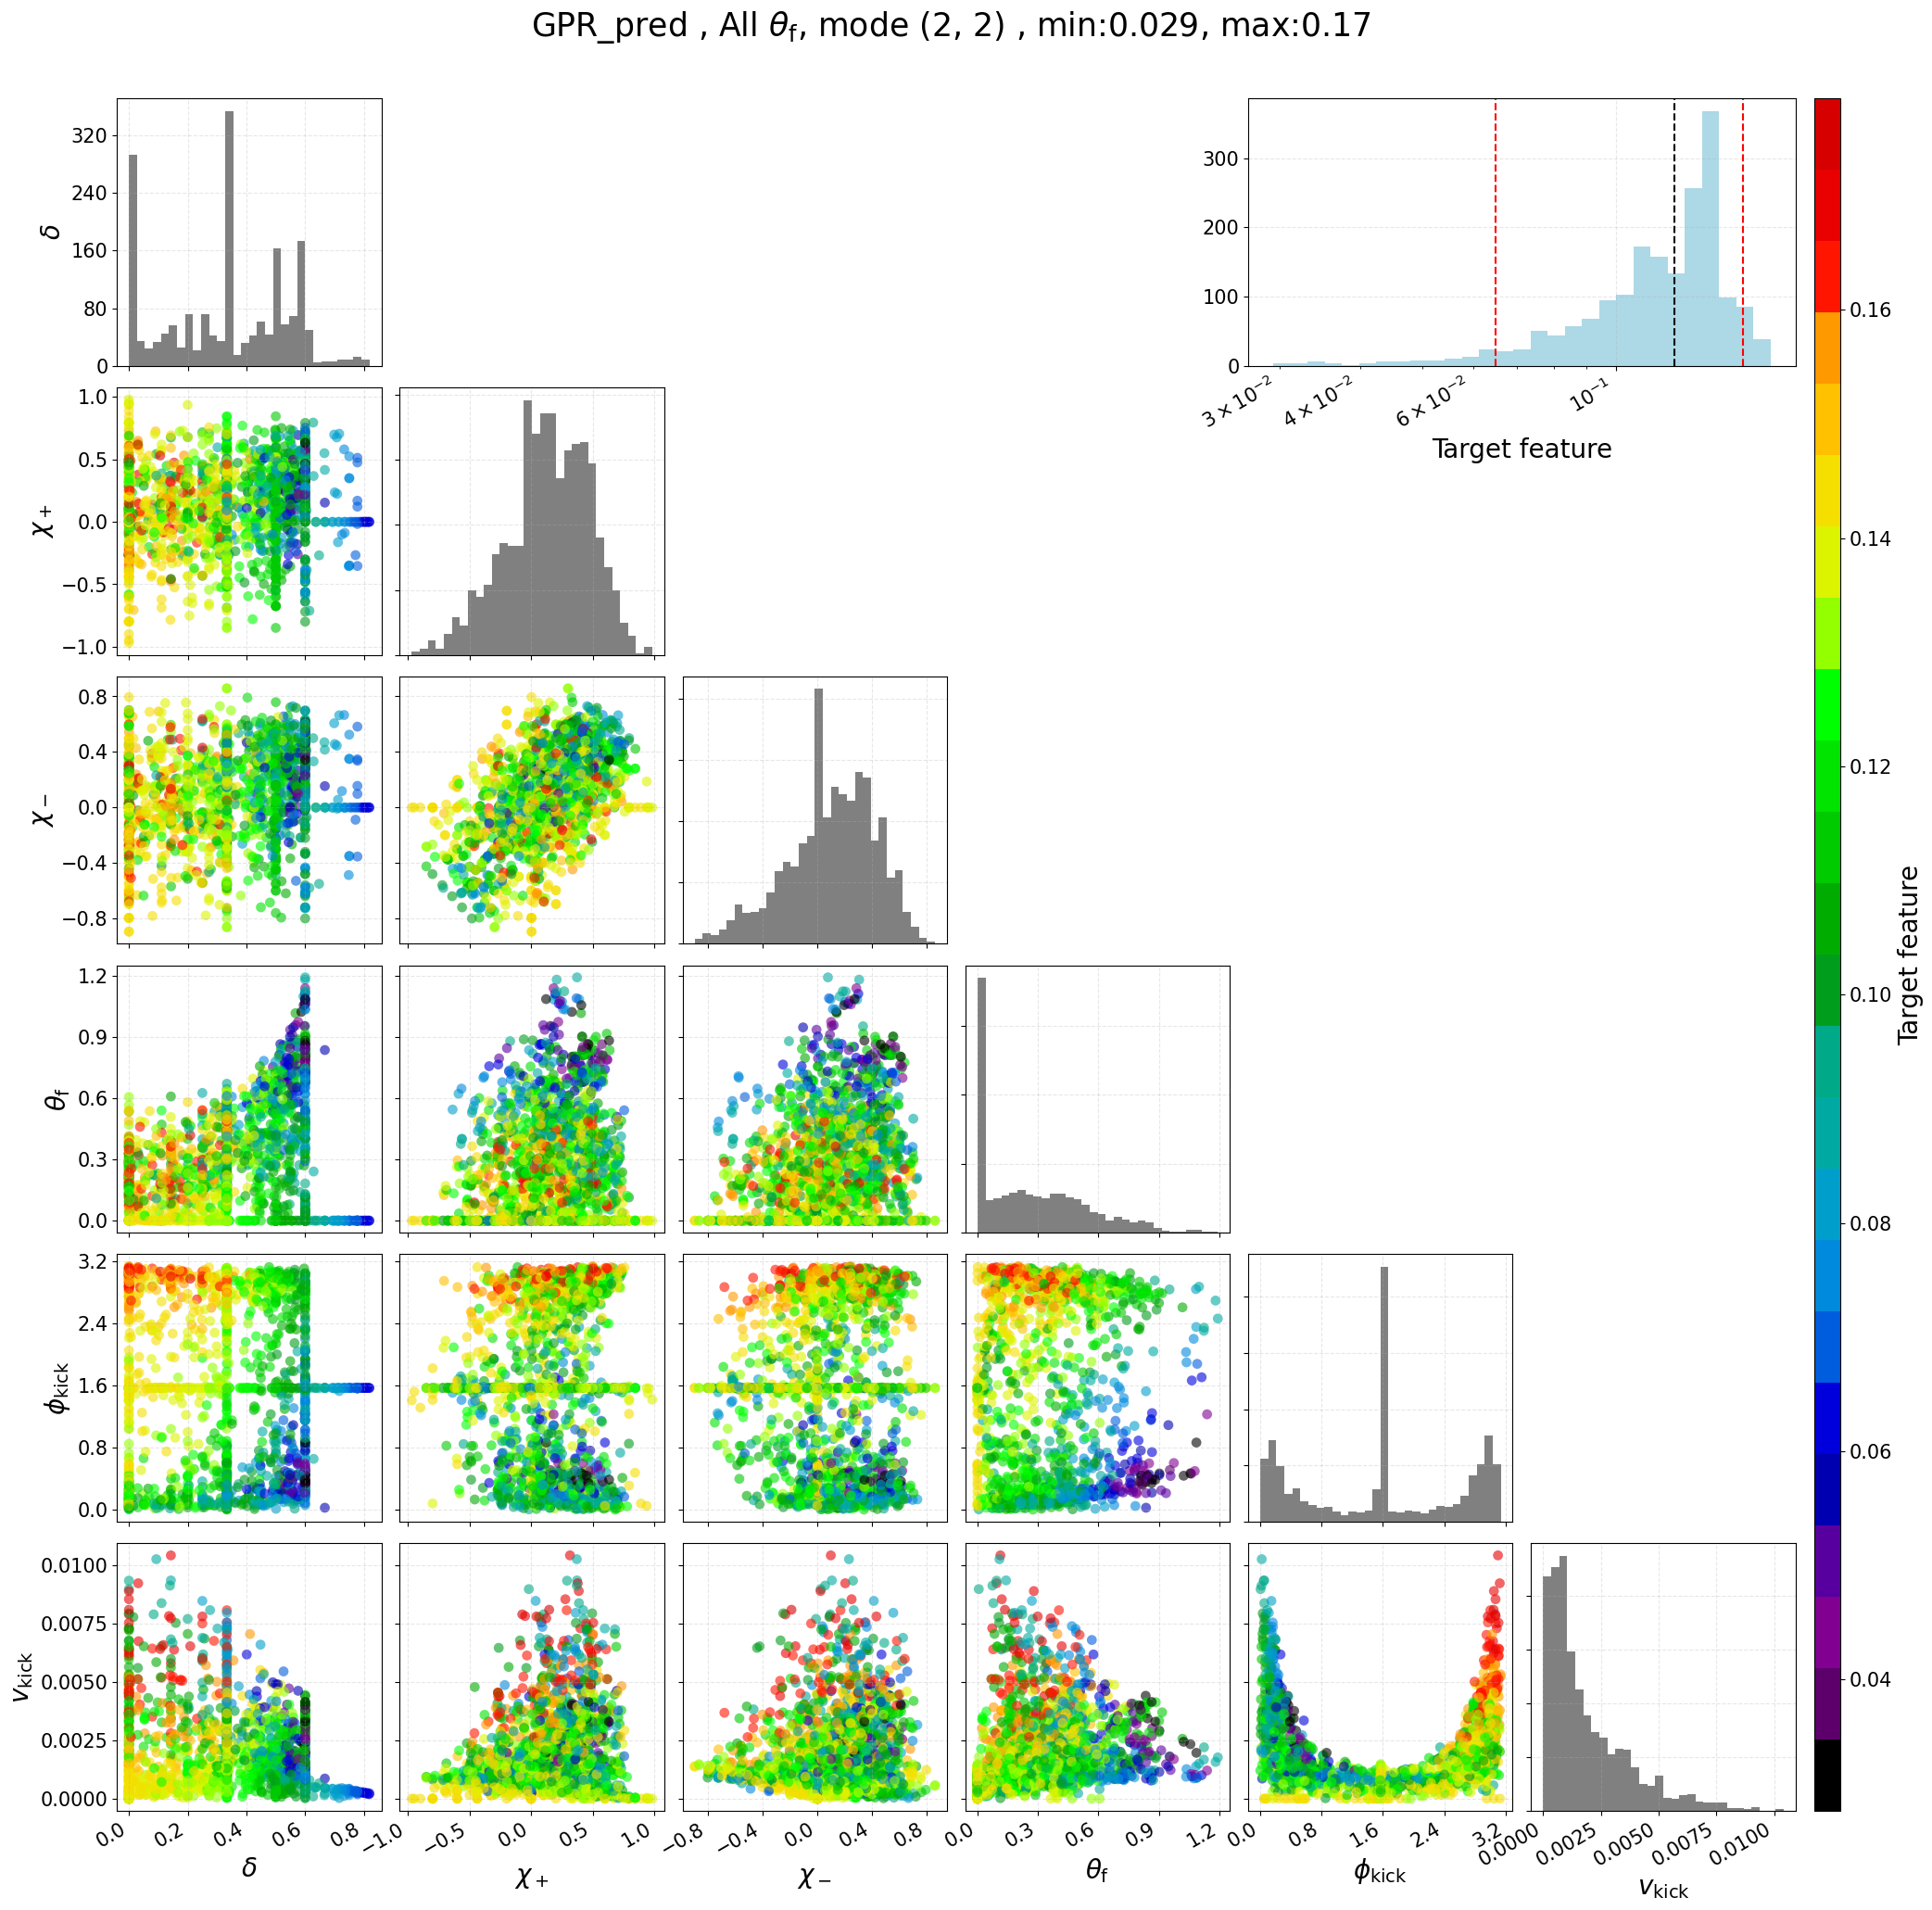

In [3]:
save_filepath = "/home/fra/ringdown/postmerger/postmerger/data/trained_models/"

# save_file = save_filepath + "Prec7dq10.pkl"
# feature_set = '7d'

save_file = save_filepath + "Prec6dq10_20M_gpr.pkl"
feature_set = '6d'


with open(save_file, "rb") as f:
    loaded_model_dict = joblib.load(f)
    
gpr_models_dict = loaded_model_dict["amps"]
# gpr_models_dict = loaded_model_dict["t_emop"]
# gpr_models_dict = loaded_model_dict["abs_err"]

# quantity = 'amplitudes'
# quantity = 'retrograde_amp'
# quantity = 't_emop'
quantity = 'GPR_pred'
# quantity = 'GPR_sigma'
# quantity = 'GPR_cv_abs_err' # 'GPR_cv_abs_err''GPR_cv_rel_err''GPR_cv_norm_err'

plot_subsample = 'all' # all small_theta big_theta aligned

ld.reset_rc()

plot_corner(quantity, 
                plot_subsample, 
                plot_t_emop_GPR=False, ##---------- Use this to plot t_emop GPR prediction
                target_hist_log=True, 
                feature_set = feature_set,
                chosen_modes=[(2,2)],
                cmap = ld.my_cmap,
                log_color=False,
                cbar_between_percentiles=False,
                savefig=False, 
                gpr_models_dict = gpr_models_dict,
                )


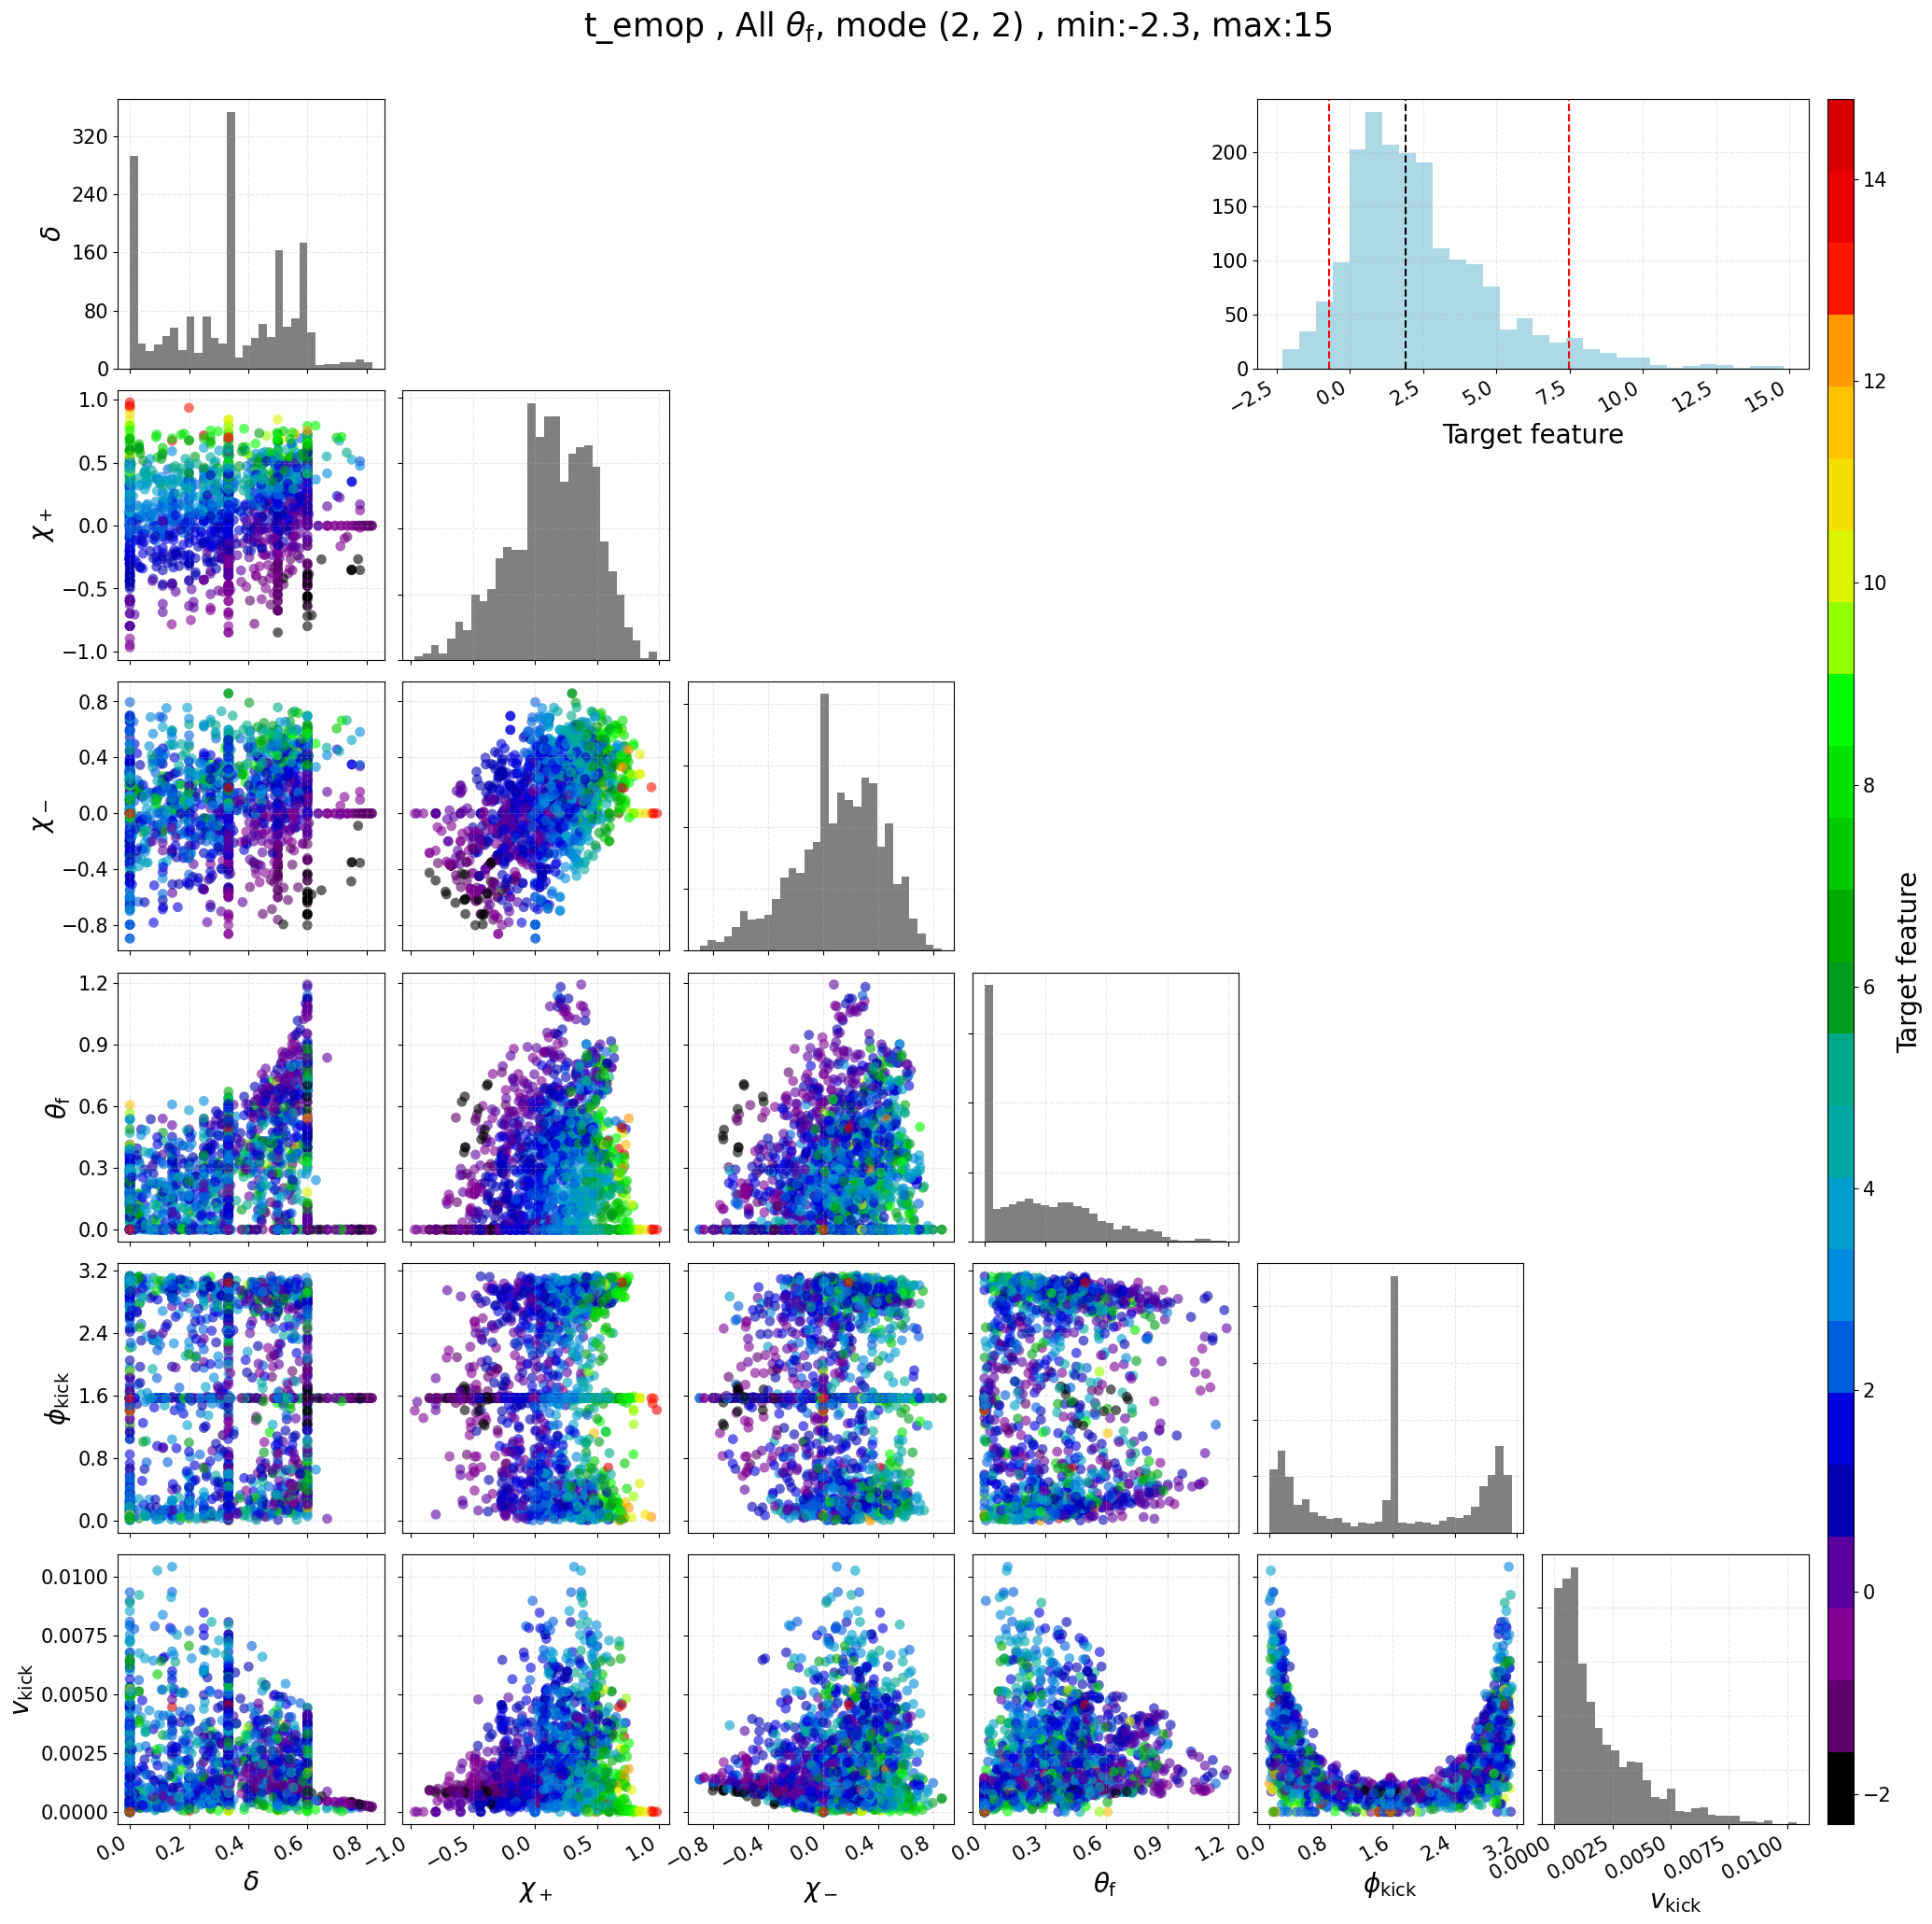